In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmmlearn import hmm
import torch
import torch.nn as nn

from model.PDV import *
from model.HMM import *
from model.data import *

# Data

In [2]:
window = 1000
log_return = True
predict_t_plus_1 = False

In [3]:
start_date = pd.to_datetime('1995-01-01')
end_date = pd.to_datetime('2023-08-31')
spx_data = pd.read_csv('spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data_nn.csv', index_col=0, parse_dates=[0])
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)
data = create_df_from_yf(spx_data, vix_data, start_date, end_date, predict_t_plus_1=predict_t_plus_1, log_return=log_return)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2023-08-24,-0.013549,1.835850e-04,0.1720
2023-08-25,0.006696,4.482973e-05,0.1568
2023-08-28,0.006245,3.900101e-05,0.1508
2023-08-29,0.014404,2.074772e-04,0.1445


# HMM for SPX

In [4]:
for n in range(2, 6):
    n_regimes = n
    spx_models = []
    print(f'Number of regimes: {n_regimes}')

    for i in range(1, 11):
        print(f'Run {i}')
        spx_model = SPXHMM(n_regimes, verbose=False)
        print(f'Initial parameters μ: {spx_model.μ}, σ: {spx_model.σ}, π: {np.exp(spx_model.π)}, A: \n{np.exp(spx_model.A)}')
        spx_model.EM_optimise(spx_data, tol=1e-7)
        spx_models.append(spx_model)
        spx_model.print_params()

        # save params to dataframe and csv
        params_df = pd.DataFrame({'n_regimes': n, 'model': i, 'μ': [spx_model.μ], 'σ': [spx_model.σ], 'π': [np.exp(spx_model.π)], 'A': [np.exp(spx_model.A)], 'log_likelihood': spx_model.log_likelihood})
        params_df.to_csv('params.csv', mode='a', header=(not os.path.exists('params.csv')))
        print('----------------------------------')

Number of regimes: 2
Run 1
Initial parameters μ: [0.11620614 0.04753128], σ: [0.27681558 0.30512724], π: [[0.40866883 0.59133117]], A: [[0.00508226 0.99491774]
 [0.92717105 0.07282895]]
Log likelihood decreased from -72881.31604853 to -73066.76166557806
μ:       [0.26  0.015]
σ:       [0.126 0.261]
π:       [0.548 0.452]
A:       
[[0.007 0.993]
 [0.901 0.099]]
----------------------------------
Run 2
Initial parameters μ: [0.0386995  0.02373449], σ: [0.28804418 0.35115704], π: [[0.04495644 0.95504356]], A: [[0.3865659 0.6134341]
 [0.1535426 0.8464574]]
Log likelihood decreased from -72167.89309285952 to -72168.26609080746
μ:       [ 0.342 -0.124]
σ:       [0.09  0.293]
π:       [0.893 0.107]
A:       
[[0.745 0.255]
 [0.245 0.755]]
----------------------------------
Run 3
Initial parameters μ: [-0.10468166 -0.05236891], σ: [0.39363352 0.29080166], π: [[0.23992546 0.76007454]], A: [[0.25111    0.74889   ]
 [0.17833723 0.82166277]]
Log likelihood decreased from -72092.5170755786 to -720

In [5]:
params_df = pd.read_csv('params.csv', index_col=0)
params_df

,n_regimes,model,μ,σ,π,A,log_likelihood
0,2,1,[0.26033976 0.01488166],[0.12631492 0.26073531],[0.54751681 0.45248319],[[0.00702196 0.99297804]\n [0.90095488 0.09904...,-72881.316049
0,2,2,[ 0.34174416 -0.12416645],[0.08952189 0.2930143 ],[0.89346575 0.10653425],[[0.74519385 0.25480615]\n [0.24459404 0.75540...,-72167.893093
0,2,3,[-0.37957292 0.29332834],[0.36678685 0.11853461],[0.00361386 0.99638614],[[0.5921114 0.4078886 ]\n [0.11878126 0.88121...,-72092.517076
0,2,4,[-0.26071205 0.29361444],[0.34089722 0.11344707],[0.0684883 0.9315117],[[0.18376854 0.81623146]\n [0.34843363 0.65156...,-72355.024308
0,2,5,[0.0358044 0.29851117],[0.2528692 0.0843239],[0.18521356 0.81478644],[[0.60007353 0.39992647]\n [0.79092979 0.20907...,-72570.743801
0,2,6,[ 0.30461596 -0.29842837],[0.11401403 0.34320322],[0.97146354 0.02853646],[[0.90030302 0.09969698]\n [0.26129444 0.73870...,-71990.861791
0,2,7,[0.28504647 0.03211657],[0.0749784 0.2598065],[0.96132298 0.03867702],[[0.29564708 0.70435292]\n [0.39890494 0.60109...,-72451.546374
0,2,8,[-0.38042628 0.28958843],[0.36960988 0.11896809],[0.79967455 0.20032545],[[0.23121995 0.76878005]\n [0.23809688 0.76190...,-72238.098646
0,2,9,[-0.09859517 0.30998338],[0.29714604 0.08947238],[0.04984242 0.95015758],[[0.52531274 0.47468726]\n [0.40728968 0.59271...,-72230.751789
0,2,10,[0.10543052 0.13252655],[0.17561721 0.21336171],[0.39384082 0.60615918],[[0.60007241 0.39992759]\n [0.05609407 0.94390...,-73406.938671


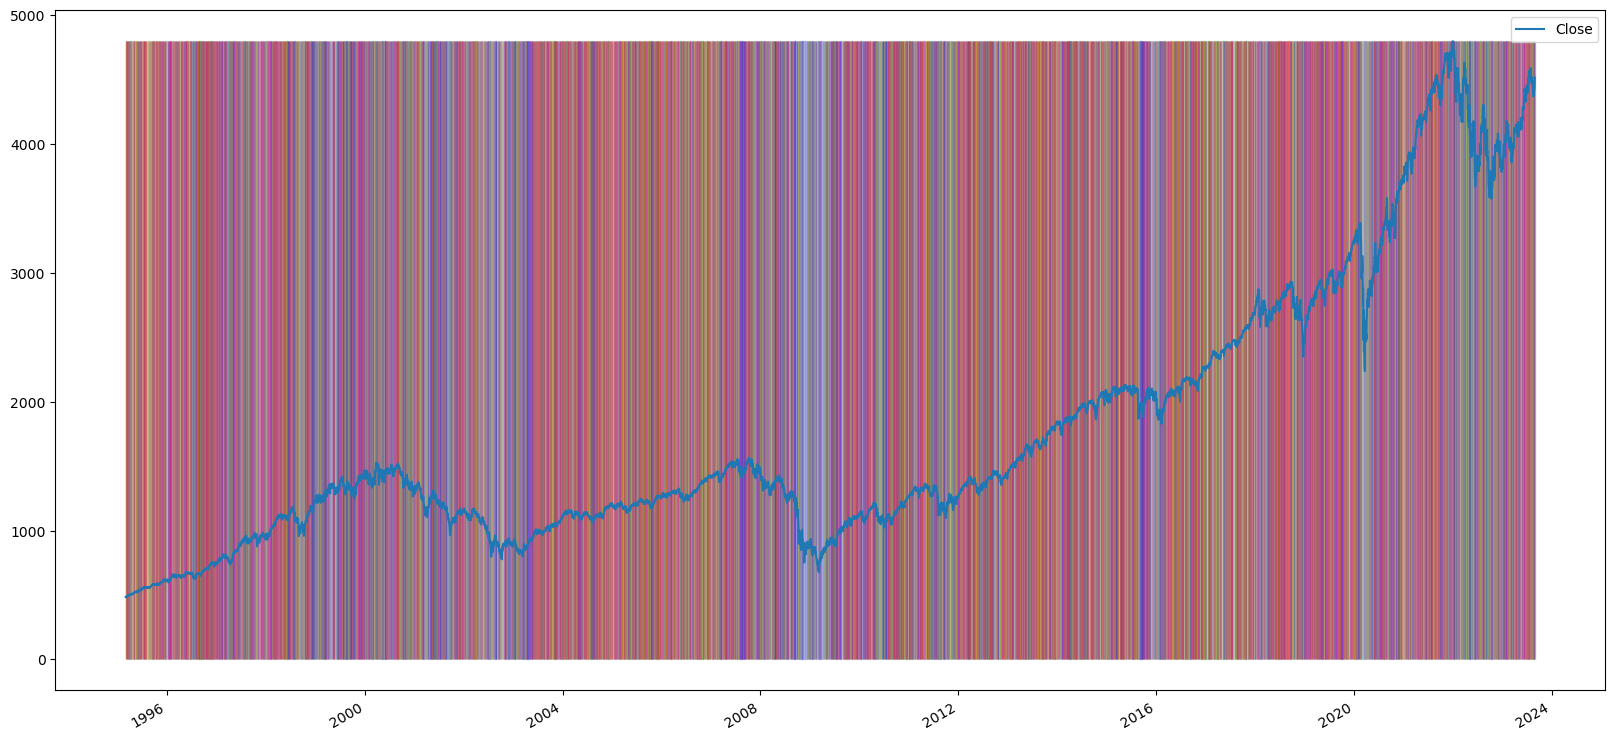

In [7]:
preds = spx_model.q_prob.argmax(axis=1)

plt.figure(figsize=(20,10))
spx_data['Close'].plot()
colors = ['g', 'r', 'b', 'y', 'm']
bool_regimes = []
for i in range(n_regimes):
    bool_regimes.append(preds == i)
    plt.fill_between(spx_data.index, spx_data['Close'].values.max(), where=bool_regimes[i], alpha=0.2, color=colors[i])

plt.legend()

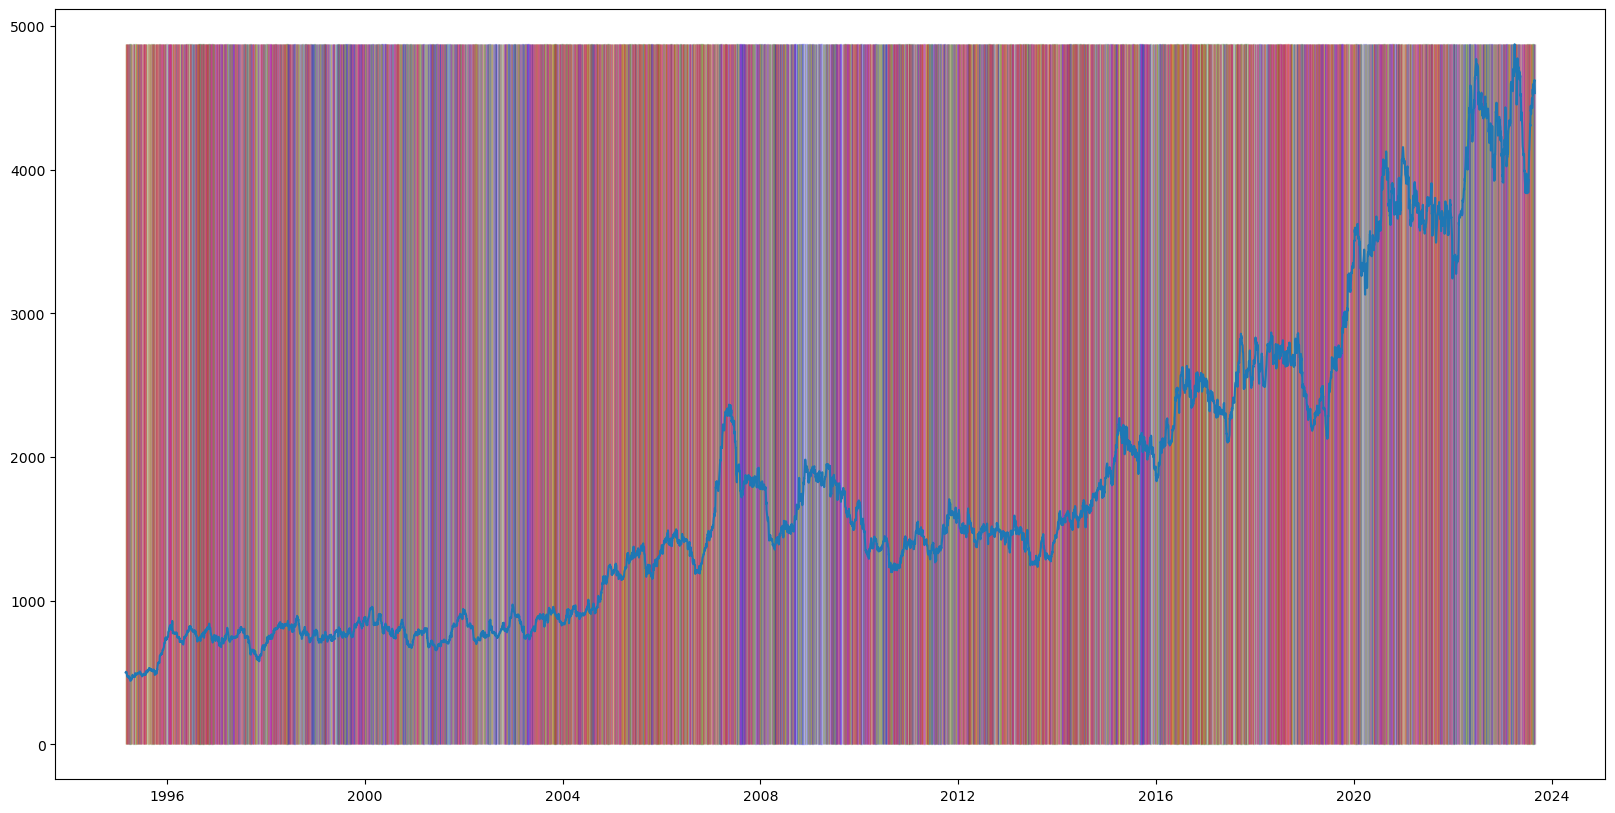

In [20]:
dt = ((spx_data.index[1:] - spx_data.index[:-1]).days / 365).values

μ = spx_model.μ
σ = spx_model.σ
π = np.exp(spx_model.π)
A = np.exp(spx_model.A)

# simulate geometric brownian motion
state = np.random.choice(n_regimes, p=π)
states = [state]
spx = [500]
for i in range(len(dt)):
    spx.append(spx[-1] * np.exp((μ[state] - σ[state]**2/2) * dt[i] + σ[state] * np.sqrt(dt[i]) * np.random.randn()))
    state = np.random.choice(n_regimes, p=A[state])
spx = np.array(spx)
plt.figure(figsize=(20,10))
plt.plot(spx_data.index, spx)
for i in range(n_regimes):
    bool_regimes.append(states == i)
    plt.fill_between(spx_data.index, spx.max(), where=bool_regimes[i], alpha=0.2, color=colors[i])

Model score: -16806.2970
Model score: -16530.9260
Model score: -16530.9311
Model score: -16530.9257
Model score: -16531.0480
Model score: -16792.0428
Model score: -16530.9255
Model score: -16530.9257
Best model: 6
Regime 0 count: 3402
Regime 1 count: 542
Regime 2 count: 3270
[ 4.28170113 24.5885454   1.22798702] [2.92811437 7.08246613 1.37810868] [-0.00522574 -0.49211783  0.27839525]
[[9.69945709e-01 7.30935826e-03 2.27449324e-02]
 [3.99997354e-02 9.60000265e-01 9.01411901e-29]
 [2.38149028e-02 9.22916285e-05 9.76092806e-01]]


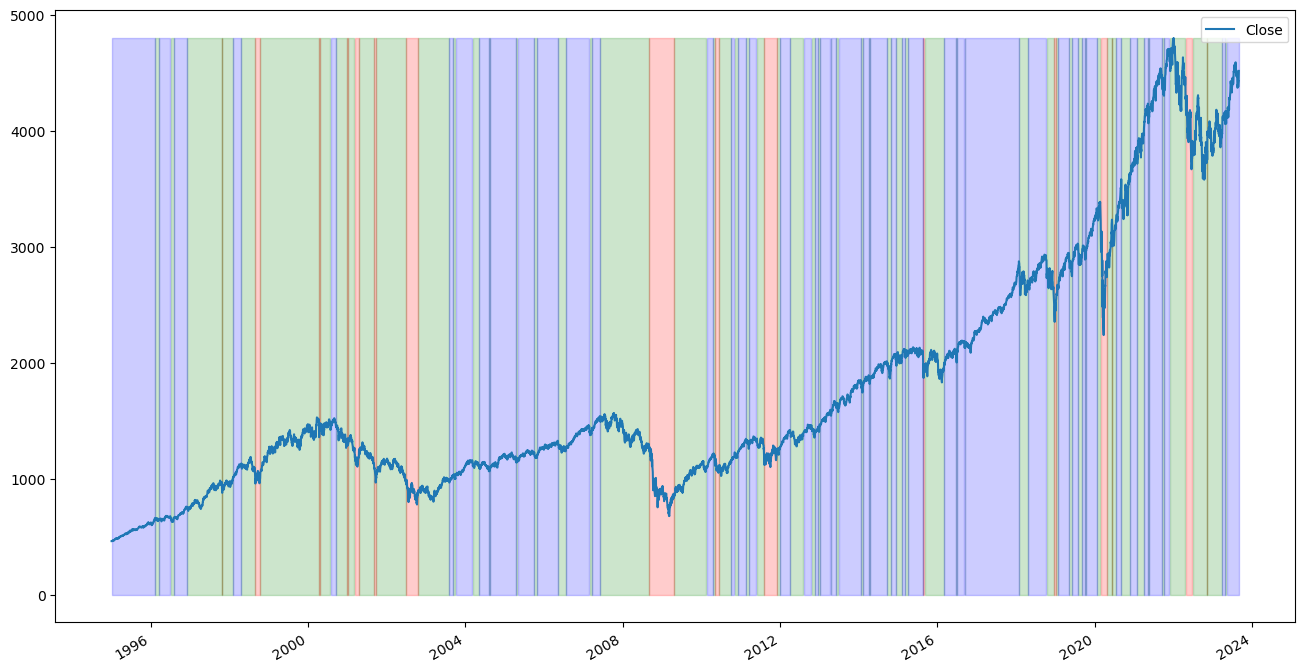

In [67]:
n_models = 8
models = []

dt = ((spx_data.index[1:] - spx_data.index[:-1]).days / 365).values
x = np.log(spx_data['Close']).diff().dropna().values[:,np.newaxis] * 252
# x = x / dt[:,np.newaxis]
episode_len = len(data) - 1

n_regimes = 3
# means = np.random.normal(0.1, 0.1, size=n_regimes)
# covar = (np.eye(3)*0.2)**2
# start_prob = np.array([0.95, 0.05]) # using high prob for regime 0 helps in stablising the permutation

for _ in range(n_models):
    # model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', means_prior=means, covars_prior=covar, startprob_prior=start_prob,
    #     n_iter=100, tol=1e-7)
    # model.init_params = ''
    model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, tol=1e-7)
    models.append(model)

high_score = -np.inf
for i in range(n_models):
    models[i].fit(x)
    preds = models[i].predict(x)

    # if using real data
    print(f'Model score: {models[i].score(x):0.4f}')

    model_score = models[i].score(x)
    if model_score > high_score:
        best_model = i
        high_score = model_score
        best_preds = preds

print(f'Best model: {best_model}')

plt.figure(figsize=(16, 9))
for i in range(n_regimes):
    print(f'Regime {i} count: {(best_preds == i).sum()}')

spx_data['Close'].plot()

colors = ['g', 'r', 'b', 'y']
bool_regimes = []
for i in range(n_regimes):
    bool_regimes.append(best_preds == i)
    plt.fill_between(spx_data.index[1:], spx_data['Close'].values.max(), where=bool_regimes[i], alpha=0.2, color=colors[i])

plt.legend()

drift = models[best_model].means_.squeeze()
volatility = models[best_model].covars_.squeeze() ** 0.5
transition = models[best_model].transmat_
mu = (drift + volatility ** 2 / 2)
sigma = volatility
print(mu, sigma, mu - sigma ** 2 / 2)
print(transition)

# PDV model for VIX

In [4]:
pdv_initial_params = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
vix_model = PDV2Exp(pdv_initial_params)
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
vix_model.optimise(data, window, lower_bound=lower_bound, upper_bound=upper_bound)
print(vix_model.params)
vix_model.evaluate(data, window)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9078e+00                                    3.06e+01    
       1              2         1.7759e+00      1.32e-01       3.63e+00       1.18e+01    
       2              3         1.7013e+00      7.46e-02       2.94e+00       2.39e-01    
       3              4         1.7002e+00      1.04e-03       1.46e+00       4.28e-01    
       4              5         1.7001e+00      1.68e-04       2.17e+00       4.07e-02    
       5              6         1.7000e+00      1.75e-05       8.13e-01       1.12e-02    
       6              7         1.7000e+00      4.01e-06       5.28e-01       3.32e-03    
       7              8         1.7000e+00      1.22e-06       2.84e-01       9.84e-04    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.9078e+00, final cost 1.7000e+00, first-order optimality 9.84e-04.
[ 5.40639378e-02 -5.64113523e-02 

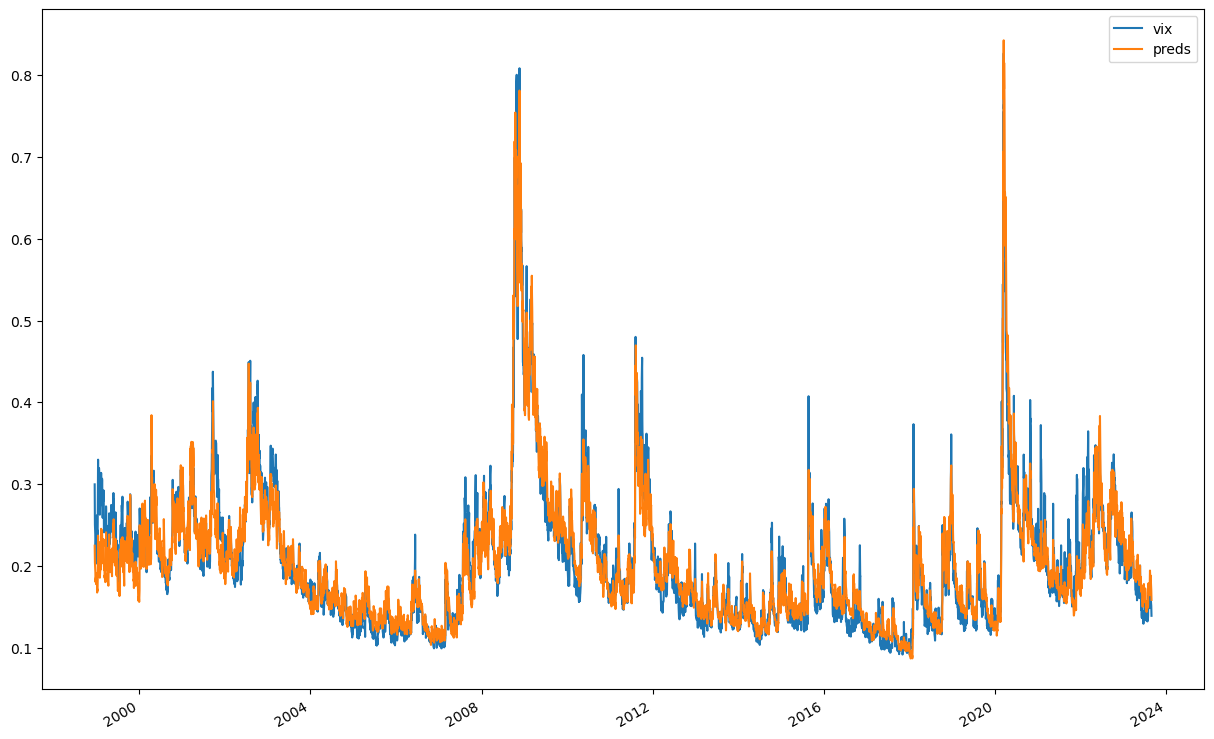

In [5]:
vix_model.plot(data, window)